In [3]:
# import os
# os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import copy
# import warnings
# from astropy import units
# from scipy import constants, interpolate, special
# from pyuvdata import UVBeam
# from pyuvdata import utils as uvutils
# from hera_cal import io, utils, vis_clean, frf, datacontainer, noise, redcal
# from hera_filters import dspec
# import hera_pspec as hp
# import uvtools
import sys

In [4]:
# %%time
# filename = "/lustre/aoc/projects/hera/h6c-analysis/IDR2/lstbin-outputs/redavg-smoothcal-inpaint-500ns-lstcal/inpaint/single_baseline_files/zen.LST.baseline.0_1.sum.uvh5"
# hd = io.HERAData(filename)
# data, flag, nsample = hd.read()

# filename = "/lustre/aoc/projects/hera/h6c-analysis/IDR2/lstbin-outputs/redavg-smoothcal-inpaint-500ns-lstcal/inpaint/single_baseline_files/zen.LST.baseline.0_0.sum.uvh5"
# # filename = "/lustre/aoc/projects/hera/jhewitt/UVorig_ee_low.uvh5"
# hd_auto = io.HERAData(filename)
# data_auto, flag_auto, nsample_auto = hd_auto.read()

In [5]:
# BAND_STR = "50.1~62.2,63.3~73.5,74.6~85.4,108.0~116.1,117.3~124.4,125.3~136.2,138.3~148.2,150.1~159.2,159.3~169.9,171.9~181.1,181.4~196.4,198.5~208.4,212.3~220.6,224.4~231.1"
# def parse_band_str(band_str: str, freqs: np.ndarray) -> tuple[float, list[float], list[float], list[float], list[slice], list[int]]:
#     """Parse a band string into a channel width and a list of slices.
    
#     Parameters
#     ----------
#     band_str : str
#         A string of comma-separated frequency bands in the form 'low~high'.
#     freqs : np.ndarray
#         An array of frequencies in Hz.
        
#     Returns
#     -------
#     df
#         The channel width in Hz.
#     bands
#         A list of the frequency bands in the form (low, high) ub Hz
#     min_freqs
#         A list of the minimum frequencies in the bands in MHz.
#     max_freqs
#         A list of the maximum frequencies in the bands in MHz.
#     band_slices
#         A list of slices corresponding to the bands.
#     nchans
#         A list of the number of channels in each band.
#     """
#     df = np.median(np.diff(freqs))
#     bands = [tuple([float(edge) for edge in band.split('~')]) for band in band_str.strip().split(',')]
#     min_freqs = [(np.min(freqs[freqs >= (1e6 * b[0])]) - df / 2) / 1e6 for b in bands]
#     max_freqs = [(np.max(freqs[freqs <= (1e6 * b[1])]) + df / 2) / 1e6 for b in bands]
#     min_chan = [np.where(freqs >= 1e6 * b[0])[0][0] for b in bands]
#     max_chan = [np.where(freqs <= 1e6 * b[1])[0][-1] for b in bands]
#     band_slices = [slice(minc, maxc+1) for minc, maxc in zip(min_chan, max_chan)]
#     nchans = [maxc - minc + 1 for minc, maxc in zip(min_chan, max_chan)]
    
#     return (
#         df,
#         bands,
#         min_freqs, 
#         max_freqs, 
#         band_slices,
#         nchans,
#     )

# df, bands, min_freqs, max_freqs, band_slices, nchans = parse_band_str(BAND_STR, data.freqs)

In [6]:
import simple_ps

# band_id = 2
# pspec_band = band_slices[band_id-1]

# beam_hera = hp.PSpecBeamUV("/lustre/aoc/projects/hera/H4C/beams/NF_HERA_Vivaldi_efield_beam_healpix.fits")
# beam_tuple = beam_hera.beam_normalized_response(pol='xx', freq=data.freqs[pspec_band])
# np.savez("/lustre/aoc/projects/hera/kfchen/H6C/forZheng/beam_info.npz", *beam_tuple)

_ = np.load("./beam_info.npz")
beam_tuple = (_['arr_0'], _['arr_1'], _['arr_2'])

### Real Visibility Case

In [7]:
# freqs_pspec = data.freqs[pspec_band]
# t_idx = 0
# data_ee = data[(0, 1, 'ee')][t_idx, pspec_band]
# data_nsample = nsample[(0, 1, 'ee')][t_idx, pspec_band]
# data_ee_auto = data_auto[(0, 0, 'ee')][t_idx, pspec_band].real

# np.save("/lustre/aoc/projects/hera/kfchen/H6C/forZheng/vis.npy", 
#         np.c_[freqs_pspec, data_ee, data_nsample, data_ee_auto])

freqs_pspec, data_ee, data_nsample, data_ee_auto = np.load("./vis.npy").T
freqs_pspec = freqs_pspec.real
data_nsample = data_nsample.real
data_ee_auto = data_ee_auto.real

invalid value encountered in divide


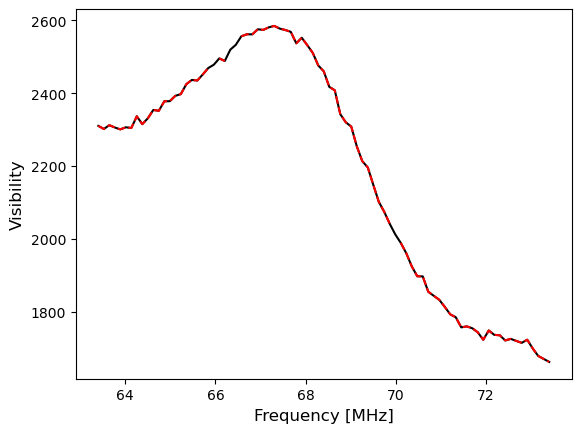

In [ ]:
flag = ~data_nsample.astype(bool)

data_ee_wFlag = copy.deepcopy(data_ee)
data_ee_wFlag[flag] = 0+0j

plt.plot(freqs_pspec/1e6, np.abs(data_ee), 'k-', label='unflagged data')
plt.plot(freqs_pspec/1e6, np.abs(data_ee_wFlag)/(~flag), 'r--', label='flagged data')

_ylim = plt.gca().get_ylim()
plt.ylim(_ylim)
plt.xlabel("Frequency [MHz]", fontsize=12)
plt.ylabel("Visibility", fontsize=12)
plt.show()

In [ ]:
# Setup pspec obj

ps_obj = simple_ps.simple_pspec(data_ee,
                                data_ee,
                                None, None, 
                                freqs=freqs_pspec,
                                beamfunc=beam_tuple, beamtype="pspec_beam",
                                cosmo=None, little_h=True,
                                vis_unit='Jy', taper='blackman-harris')    

dt = 9.663676416 # np.median(hd.integration_time)
df = 122070.3125 #np.median(np.diff(hd.freq_array))
sigma = data_ee_auto*ps_obj.Jy2mK/np.sqrt(dt*df*data_nsample.max()) #in mK

Cnos = np.diag(sigma**2)
ps, ps_cov = ps_obj.p_hat(calc_cov=True, Cnos1=Cnos)

ps_obj = simple_ps.simple_pspec(data_ee_wFlag,
                                data_ee_wFlag,
                                None, None, 
                                freqs=freqs_pspec,
                                beamfunc=beam_tuple, beamtype="pspec_beam",
                                cosmo=None, little_h=True,
                                vis_unit='Jy', taper='blackman-harris')     


ps_wFlag = ps_obj.p_hat()

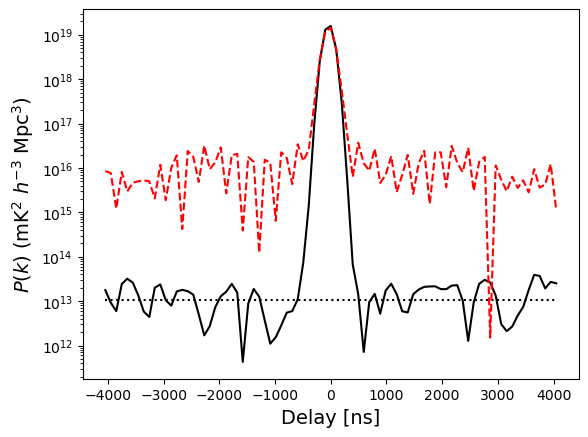

In [ ]:
plt.plot(ps_obj.delays*1e9, ps.real, 'k-', label='unflagged')
plt.plot(ps_obj.delays*1e9, np.sqrt(np.diag(ps_cov.real)), 'k:')
plt.plot(ps_obj.delays*1e9, ps_wFlag.real, 'r--', label='flagged')
plt.yscale("log")
plt.xlabel("Delay [ns]", fontsize=14)
plt.ylabel(r"$P(k)$ (mK$^2$ $h^{-3}$ Mpc$^3$)", fontsize=14)
plt.show()

### Noise-only Case

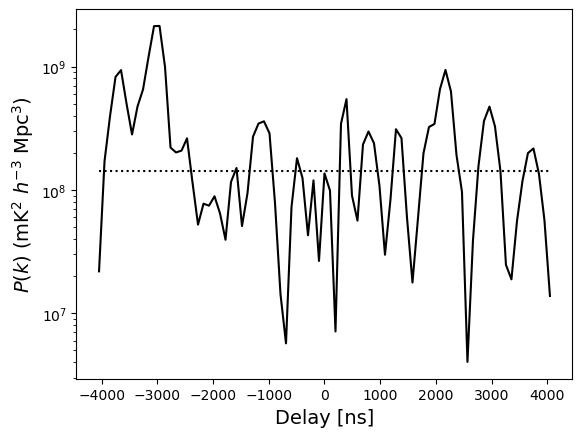

In [11]:
sigma = np.ones(freqs_pspec.size)
rng = np.random.default_rng()
noise_rlz = rng.normal(scale=sigma/np.sqrt(2)) + 1j*rng.normal(scale=sigma/np.sqrt(2))

ps_obj = simple_ps.simple_pspec(noise_rlz,
                                noise_rlz,
                                None, None, 
                                freqs=freqs_pspec,
                                beamfunc=beam_tuple, beamtype="pspec_beam",
                                cosmo=None, little_h=True,
                                vis_unit='mK', taper='blackman-harris')    

ps, ps_cov = ps_obj.p_hat(calc_cov=True, Cnos1=np.diag(sigma**2))


plt.plot(ps_obj.delays*1e9, ps.real, 'k-')
plt.plot(ps_obj.delays*1e9, np.sqrt(np.diag(ps_cov.real)), 'k:')

plt.yscale("log")
plt.xlabel("Delay [ns]", fontsize=14)
plt.ylabel(r"$P(k)$ (mK$^2$ $h^{-3}$ Mpc$^3$)", fontsize=14)

plt.show()